# California housing dataset 
## Part II: Feature engineering, hyperparameter tuning

### Goals:
- Feature selection and egineering
- Hyperparameter tuning
- Beat the baseline's performance

In [22]:
from __future__ import print_function

import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.ERROR)

In [23]:
# Load the data
cali_housing_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
# Rescale median_house_value (target variable) to reasonable bounds
cali_housing_data["median_house_value"] /= 1000
# Randomize the data
cali_housing_data = cali_housing_data.reindex(np.random.permutation(cali_housing_data.index))

## Bucketization
Let's try to bin the values of features instead of using numeric ones. I'll be using 10 bins per each. `get_quantile_based_boundaries` ensures that the bucket boundaries in such a way that each bucket has the same number of examples.

In [24]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

def numeric_feature_columns(features, dataset):
    numeric = []
    for feature in features:
        numeric.append(tf.feature_column.numeric_column(feature))
    return set(numeric)

def bucketize_feature_columns(features, dataset):
    bucketized = []
    for feature in features:
        bucketized.append(tf.feature_column.bucketized_column(tf.feature_column.numeric_column(feature), 
            boundaries=get_quantile_based_boundaries(dataset[feature], 10)))
    return set(bucketized)

In [29]:
from data_sci_helpers.tf import input_func

def train(X_train, y_train, X_valid, y_valid, feature_columns, lr, steps, batch_size, periods):
    # Create input functions.
    training_input_fn = lambda:input_func(X_train, y_train, batch_size=batch_size)
    prediction_input_fn = lambda:input_func(X_train, y_train, num_epochs=1, shuffle=False)
    prediction_validation_input_fn = lambda: input_func(X_valid, y_valid, num_epochs=1, shuffle=False)
    # 2. Configure the linear regression model
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=optimizer
    )
    root_mean_squared_errors = []
    validation_root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps/periods
        )
        # Compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        rmse = math.sqrt(metrics.mean_squared_error(predictions, y_train))

        validation_predictions = linear_regressor.predict(input_fn=prediction_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        valid_rmse = math.sqrt(metrics.mean_squared_error(validation_predictions, y_valid))
        # Print the loss
        print(f"Period {period} : Training RMSE: {rmse} ; Valid. RMSE: {valid_rmse} ")
        root_mean_squared_errors.append(rmse)
        validation_root_mean_squared_errors.append(valid_rmse)

    plt.subplot(1, 2, 1)
    plt.title(f"RMSE vs. Periods")
    plt.plot(root_mean_squared_errors)

    plt.subplot(1, 2, 2)
    plt.title(f"Validation RMSE vs. Periods")
    plt.plot(validation_root_mean_squared_errors)
    return linear_regressor

Period 0 : Training RMSE: 198.97092322934938 ; Valid. RMSE: 196.1801232571377 
Period 1 : Training RMSE: 163.2210076299779 ; Valid. RMSE: 160.1121134172356 
Period 2 : Training RMSE: 133.5987462382272 ; Valid. RMSE: 130.24958694964877 
Period 3 : Training RMSE: 113.75003172034906 ; Valid. RMSE: 110.20708927562966 
Period 4 : Training RMSE: 104.01544005696088 ; Valid. RMSE: 100.38399893693665 
Period 5 : Training RMSE: 98.15073259946007 ; Valid. RMSE: 94.50029265443773 
Period 6 : Training RMSE: 93.35062306379349 ; Valid. RMSE: 89.50514851057636 
Period 7 : Training RMSE: 89.14317578383952 ; Valid. RMSE: 85.28267937670458 
Period 8 : Training RMSE: 85.84033450398321 ; Valid. RMSE: 81.70637386611514 
Period 9 : Training RMSE: 83.19090471332883 ; Valid. RMSE: 78.93432846581047 
Period 10 : Training RMSE: 80.5422724246675 ; Valid. RMSE: 76.32022870804441 
Period 11 : Training RMSE: 78.91750744364576 ; Valid. RMSE: 74.58418869958193 
Period 12 : Training RMSE: 77.82864424884907 ; Valid. RMS

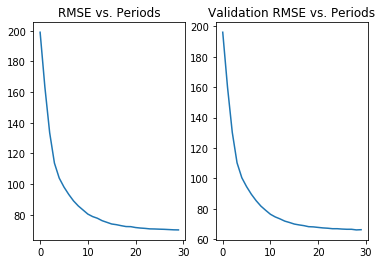

In [26]:
target = "median_house_value"
features = [item for item in list(cali_housing_data.columns) if item != target]
X = cali_housing_data[features]
y = cali_housing_data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

bucketized_features = bucketize_feature_columns(features, X_train)
bucketized_linear_regressor = train(X_train, y_train, X_valid, y_valid, bucketized_features, 1.0, 200, 100, 30)

The performance with bucketized features is remarkably better than with numerical ones, as seen in tha baseline model of Part I. I could increase the learning rate up to 1.0 (compared to only 0.0005 in the baseline model) without any loss in convergence.

## Outlier clipping
In Part I there have been some unfortunate distribution plots for the 4 correlated features: `total_rooms`, `total_bedrooms`, `population` and `households`. Let's try to clip some outliers so that they don't skew the predictions:

In [27]:
from data_sci_helpers.manipulation import clip_values_above_threshold, how_many_values_above_threshold

print(how_many_values_above_threshold(cali_housing_data, "total_rooms", 7500))
print(how_many_values_above_threshold(cali_housing_data, "total_bedrooms", 1500))
print(how_many_values_above_threshold(cali_housing_data, "population", 5000))
print(how_many_values_above_threshold(cali_housing_data, "households", 1500))

531
563
265
423


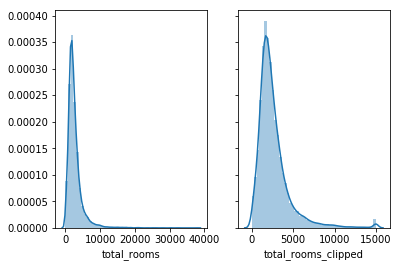

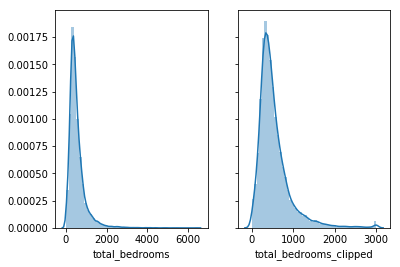

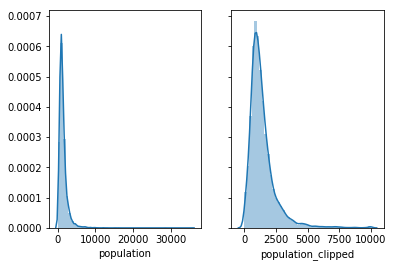

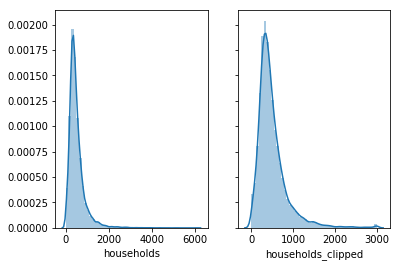

In [28]:
from data_sci_helpers.visualization import plot_2_distributions
cali_housing_data["total_rooms_clipped"] = clip_values_above_threshold(cali_housing_data["total_rooms"], 15000)
cali_housing_data["total_bedrooms_clipped"] = clip_values_above_threshold(cali_housing_data["total_bedrooms"], 3000)
cali_housing_data["population_clipped"] = clip_values_above_threshold(cali_housing_data["population"], 10000)
cali_housing_data["households_clipped"] = clip_values_above_threshold(cali_housing_data["households"], 3000)

plot_2_distributions(cali_housing_data["total_rooms"], cali_housing_data["total_rooms_clipped"])
plot_2_distributions(cali_housing_data["total_bedrooms"], cali_housing_data["total_bedrooms_clipped"])
plot_2_distributions(cali_housing_data["population"], cali_housing_data["population_clipped"])
plot_2_distributions(cali_housing_data["households"], cali_housing_data["households_clipped"])

In [ ]:
clipped_features = ["total_rooms_clipped", "total_bedrooms_clipped", "population_clipped", "households_clipped",
           "longitude", "latitude", "housing_median_age", "median_income"]
X = cali_housing_data[clipped_features]
y = cali_housing_data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
bucketized_features = bucketize_feature_columns(clipped_features, X_train)
clipped_linear_regressor = train(X_train, y_train, X_valid, y_valid, bucketized_features, 1.0, 200, 100, 20)

Period 0 : Training RMSE: 182.67594897632813 ; Valid. RMSE: 182.80105913314617 
Period 1 : Training RMSE: 136.93525999645752 ; Valid. RMSE: 136.9525016724173 
Period 2 : Training RMSE: 109.27353575020796 ; Valid. RMSE: 109.32268240312311 


### Creating other features:
- feature cross
- is_LA feature - longitude and latitude reached surprisingly good RMSE, i'll check them further and use this feature as well
- rooms_per_person

#### 1. Feature crosses:
- try a lat-x-long feature cross

In [82]:
bucketized_longitude = [item for item in list(bucketized_features) if item.source_column.key == "longitude"][0]
bucketized_latitude = [item for item in list(bucketized_features) if item.source_column.key == "latitude"][0]

In [84]:
long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
bucketized_features.add(long_x_lat)

Period 0 : Training RMSE: 135.26758766869875 ; Valid. RMSE: 137.95077578219852 
Period 1 : Training RMSE: 96.2526898464086 ; Valid. RMSE: 97.73311804372455 
Period 2 : Training RMSE: 82.72560240945616 ; Valid. RMSE: 83.8483780680748 
Period 3 : Training RMSE: 74.94791428349127 ; Valid. RMSE: 75.85324834247068 
Period 4 : Training RMSE: 71.32626931224654 ; Valid. RMSE: 72.23015749219546 
Period 5 : Training RMSE: 68.40914678657393 ; Valid. RMSE: 68.89205969557227 
Period 6 : Training RMSE: 66.97372154414278 ; Valid. RMSE: 67.42833227144685 
Period 7 : Training RMSE: 66.0325240152053 ; Valid. RMSE: 66.22132999727783 
Period 8 : Training RMSE: 65.54432526276621 ; Valid. RMSE: 65.62328657526717 
Period 9 : Training RMSE: 65.57420848272635 ; Valid. RMSE: 65.93866837152608 


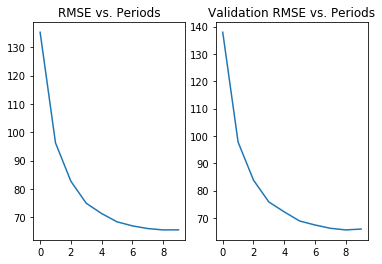

In [86]:
train(X_train, y_train, X_valid, y_valid, bucketized_features, 1.0, 200, 100, 10)

## Hyperparameter optimization
- different optimizers - FtrlOptimizer
- different models